In [1]:
import numpy as np
import itertools
from adadelta import adadelta
import scipy.optimize as optimize

class LinearRegression:
    def __init__(self,X: np.ndarray,
                 y: np.ndarray,
                 degree: int =1,
                 lam: int =0,
                 normalize: bool = False):
        if X.ndim == 1: 
            X = X[:,None]
        self.mu = self.sigma = None
        if normalize:
            X,self.mu,self.sigma = self.FeatureNormalize(X)
        m,n = X.shape
        self.degree = degree
        self.lam = lam
        self.X = self.generate_polynomial(X,degree=degree)
        self.m,self.n = self.X.shape
        self.y = np.array(y,copy=True)
    def __call__(self,*args,
                 theta: np.ndarray =None,
                 **kwargs) -> tuple:
        res = []
        def callback(x):
            res.append([*x,self.J(x)])
        m,n = self.m,self.n
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = np.zeros(n)
        optimize.minimize(self.J,theta,jac=self.dJdTheta,**kwargs,callback=callback)
        res = np.array(res)
        return res[:,:-1],res[:,-1]
    def adadelta(self,*args,
                 theta: np.ndarray = None,
                 **kwargs) -> tuple:
        m,n = self.m,self.n
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = np.zeros(n)
        ad = adadelta(self.J,grad=self.dJdTheta)
        theta = ad.minimize(theta,*args,**kwargs)
        thetas,Js = ad.xs,ad.fs
        return thetas,Js
    def GradientDescent(self,
                        alpha: float,
                        theta: np.ndarray = None,
                        steps:int = 1000) -> tuple:
        m,n = self.m,self.n
        lam = self.lam
        if theta is not None:
            theta = np.array(theta,copy=True)
        else:
            theta = np.zeros(n)
        res = []
        for i in range(steps):
            theta = theta - alpha*self.dJdTheta(theta)
            J = self.J(theta)
            res.append([*theta,J])
        res = np.array(res)
        _theta = res[:,:-1]
        _J = res[:,-1]
        return _theta,_J
    def generate_polynomial(self,
                            X: np.ndarray,
                            degree: int = 1) -> np.ndarray:
        m,n = X.shape
        perm = itertools.product(
                range(degree+1),repeat=n)
        powers = []
        for p in list(perm):
            if(np.sum(p)<=degree):
                powers.append(p)
        powers = np.array(powers)
        X_new = []
        for row in X:
            res = []
            for p in powers:
                res.append(np.prod(row**p))
            X_new.append(res)
        X_new = np.array(X_new)
        return X_new
    def FeatureNormalize(self,
                         X: np.ndarray) -> np.ndarray:
        X = np.array(X,copy=True)
        m,n = X.shape
        mu = np.mean(X,axis=0)
        sigma = np.std(X,axis=0,ddof=1)
        for i in range(n):
            X[:,i] = (X[:,i] - mu[i])/(sigma[i] + 1e-100)
        return X,mu,sigma
    def h(self,
          X: np.ndarray,
          theta: np.ndarray) -> np.ndarray:
        return X@theta
    def J(self,
          theta: np.ndarray) -> np.ndarray:
        m,n = self.m,self.n
        lam = self.lam
        err = self.h(self.X,theta) - self.y
        j = 1/(2*m)*err@err + lam/(2.*m)*theta[1:]@theta[1:]
        return j
    def dJdTheta(self,
                 theta: np.ndarray) -> np.ndarray:
        m,n = self.m,self.n
        lam = self.lam
        dJ = 1/m*self.X.T@(self.h(self.X,theta)-self.y) + lam/m*theta
        dJ[0] = dJ[0] - lam/m*theta[0]
        return dJ
    def NormalEqn(self) -> np.ndarray:
        X,y,lam = self.X,self.y,self.lam
        XT = X.T
        L = np.identity(self.n)
        L[0,0] = 0
        return np.linalg.pinv(XT@X + lam*L)@XT@y
    def predict(self,
                X: np.ndarray,
                theta: np.ndarray) -> np.ndarray:
        X = np.array(X,copy=True)
        if X.ndim == 1: 
                X = X[:,None]
        if self.mu is not None:
            m,n = X.shape
            for i in range(n):
                X[:,i] = (X[:,i] - self.mu[i])/(self.sigma[i] + 1e-100) 
        X = self.generate_polynomial(X,degree=self.degree) 
        theta = np.array(theta,copy=True)
        return self.h(X,theta)

Error in theta from scipy =  4.16821421822533e-09
Error in theta from gradient descent =  0.0006344510302369599
Error in theta from adadelta =  0.09344015943588602


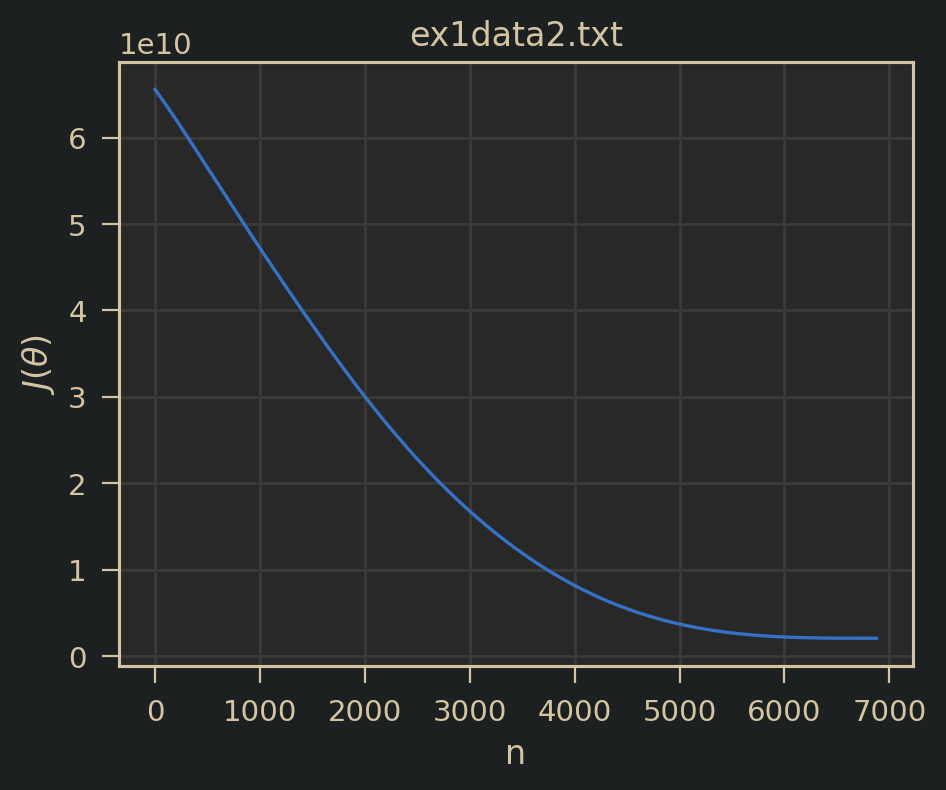

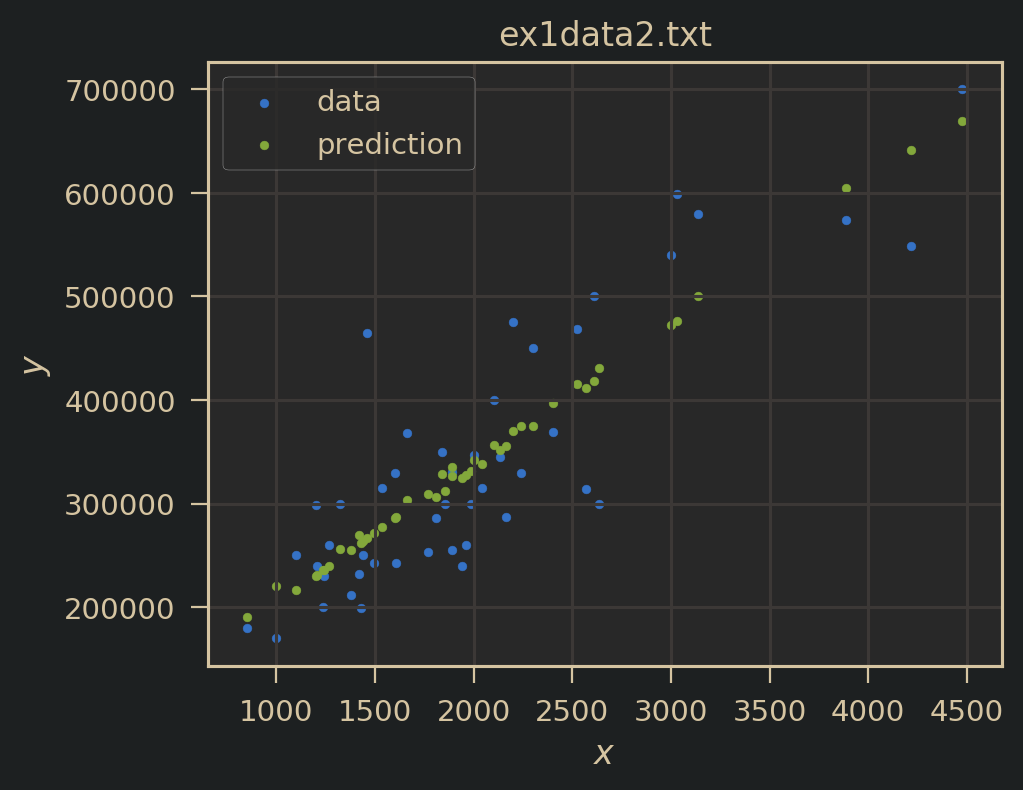

Error in theta from scipy =  2.6287344390141243e-07
Error in theta from gradient descent =  2.1479778844479824e-08
Error in theta from adadelta =  3.2148353774630323e-06


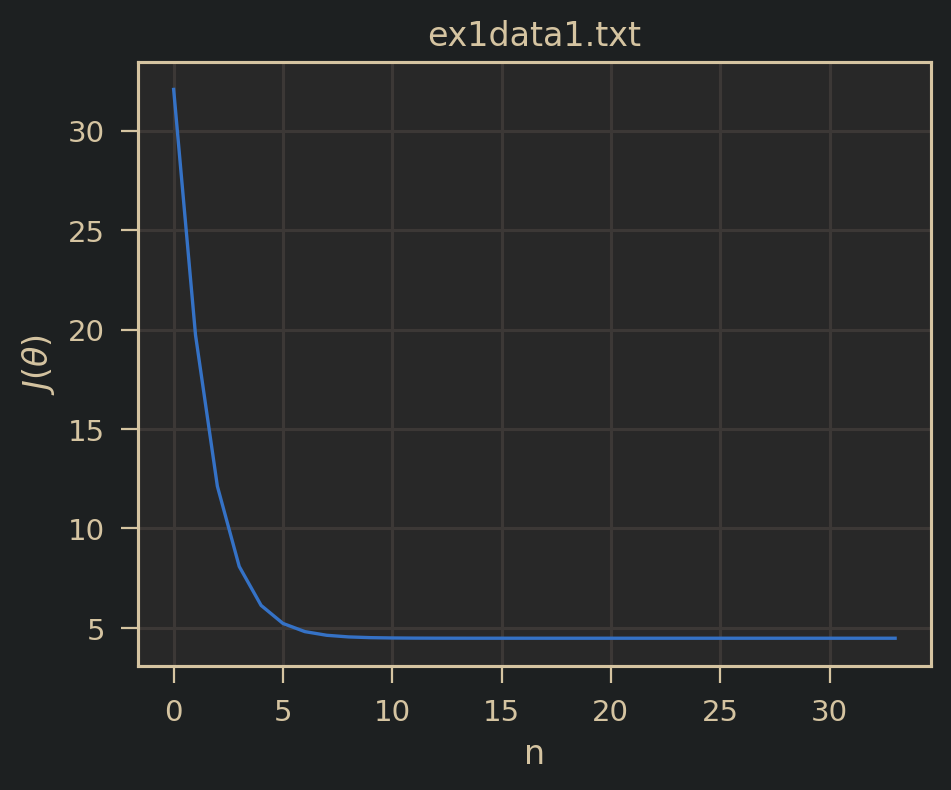

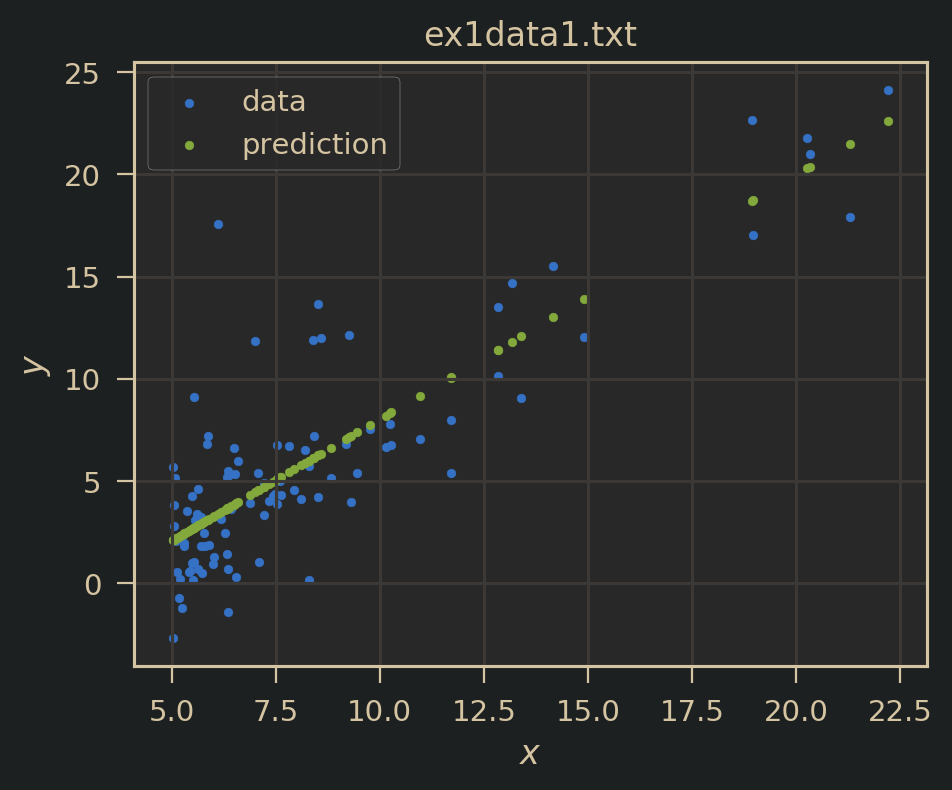

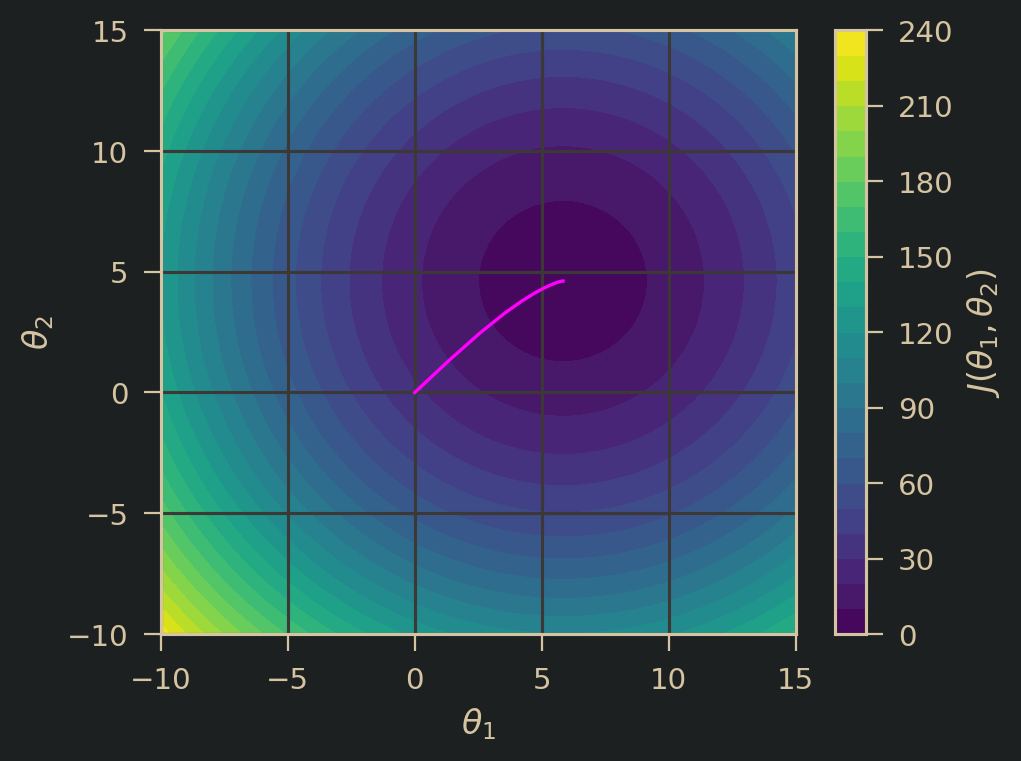

Error in theta =  9.280019335200507e-07


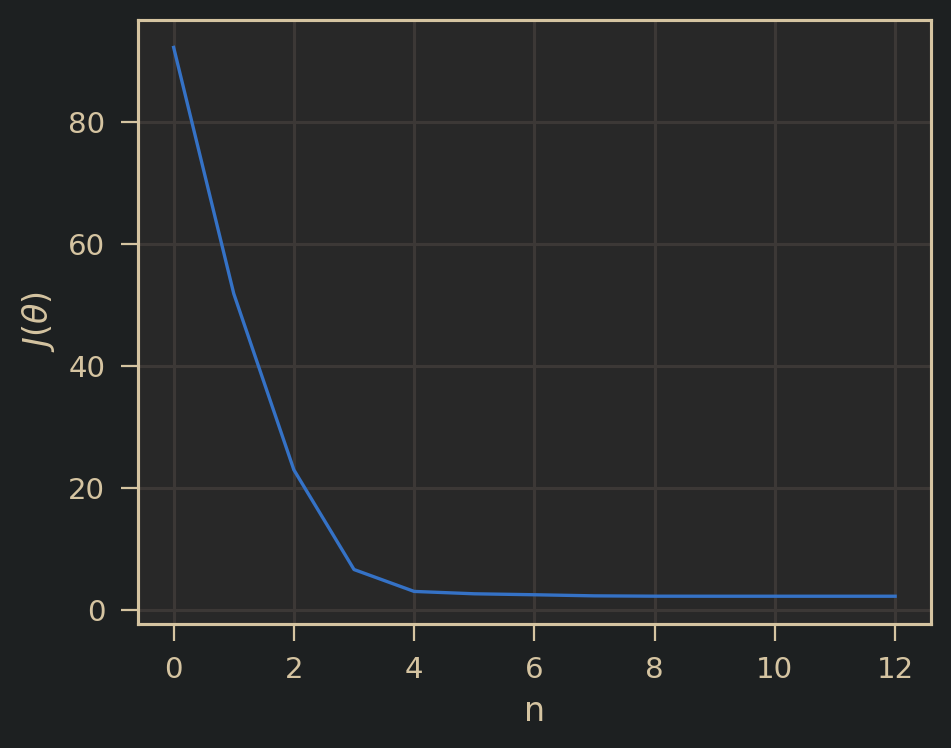

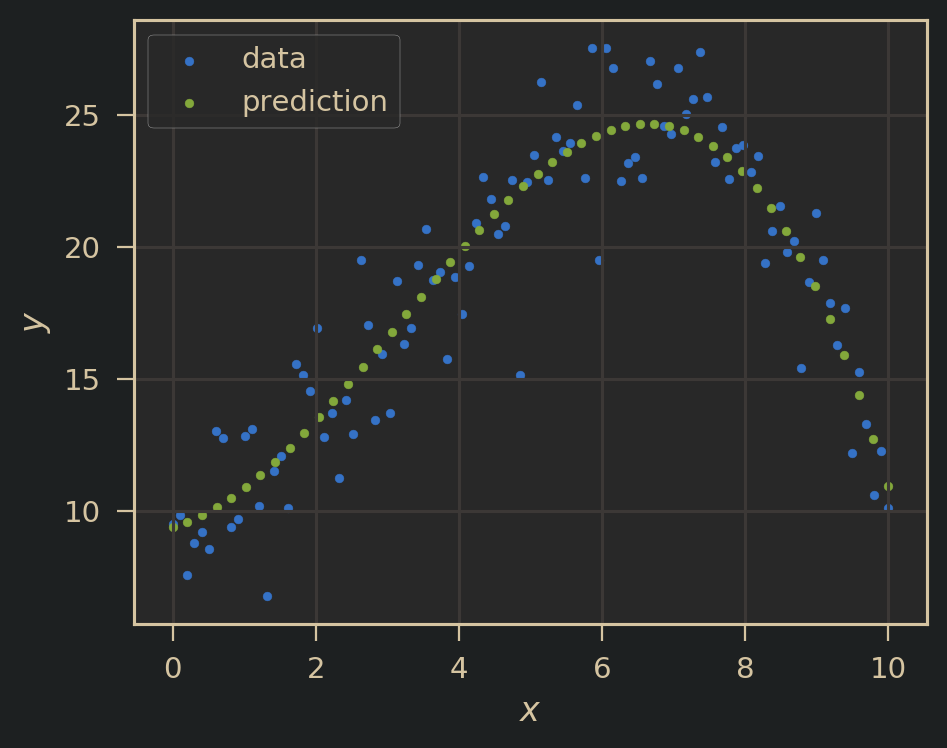

In [2]:
if (__name__ == "__main__") :
    import matplotlib.pyplot as plt
    from jupyterthemes import jtplot
    jtplot.style(theme="gruvboxd",
                 #context="notebook", 
                 ticks=True,
                 fscale=1.0,
                 figsize=(6.4,4.9),
                 grid=True)
    file = ["ex1data2.txt","ex1data1.txt"]
    eps = [50,0.1]
    for (_file,_eps) in zip(file,eps):

        with open(_file,"rb") as f:
            data = np.loadtxt(f,delimiter=",")
        X = data[:,0:-1]
        y = data[:,-1]

        LR = LinearRegression(X,y,
                              degree=1,
                              lam=0,
                              normalize=True)
        _theta,J = LR()
        theta = _theta[-1]
        print("Error in theta from scipy = ",np.sqrt(np.sum(theta - LR.NormalEqn())**2))
        _theta,J = LR.GradientDescent(0.01,steps=2000)
        theta = _theta[-1]
        print("Error in theta from gradient descent = ",np.sqrt(np.sum(theta - LR.NormalEqn())**2))
        _theta,J = LR.adadelta(rho=0.95,rtol=1e-12,atol=0,eps=_eps)
        theta = _theta[-1]
        print("Error in theta from adadelta = ",np.sqrt(np.sum(theta - LR.NormalEqn())**2))

        fig,ax = plt.subplots()
        ax.set(xlabel="n",ylabel=r"$J(\theta)$",title=_file)
        ax.plot(J)
        plt.show()

        fig,ax = plt.subplots()
        ax.scatter(X[:,0],y,label="data",s=10)
        ax.scatter(X[:,0],LR.predict(X,theta),label="prediction",s=10)
        ax.set(xlabel="$x$",ylabel="$y$",title=_file)
        plt.legend()
        plt.show()

    thetas = np.linspace(-10,15,100)
    theta1,theta2 = np.meshgrid(thetas,thetas)
    theta = np.column_stack((theta1.ravel(),theta2.ravel()))
    J = [LR.J(theta[i]) for i in range(len(theta))]
    J = np.array(J).reshape(*theta1.shape)
    fig,ax = plt.subplots()
    ax.set(xlabel=r"$\theta_1$",ylabel=r"$\theta_2$")
    cntr = ax.contourf(theta1,theta2,J,25)
    fig.colorbar(cntr,label=r"$J(\theta_1,\theta_2)$")
    ax.plot(*_theta.T,color="magenta")
    plt.show()
    
    X = np.linspace(0,10,100)
    y = 10 - 0.1*X**3 + X**2 + 2*np.random.randn(len(X))

    LR = LinearRegression(X,y,
                          lam=1,
                          degree=3,
                          normalize=True)
    _theta,J = LR()#.GradientDescent(0.01,steps=10000)
    theta = _theta[-1]
    print("Error in theta = ",np.sqrt(np.sum(theta - LR.NormalEqn())**2))

    fig,ax = plt.subplots()
    ax.set(xlabel="n",ylabel=r"$J(\theta)$")
    ax.plot(J)
    plt.show()

    Xnew = np.linspace(0,10,50)
    fig,ax = plt.subplots()
    ax.scatter(X,y,label="data",s=10)
    ax.scatter(Xnew,LR.predict(Xnew,theta),label="prediction",s=10)
    ax.set(xlabel="$x$",ylabel="$y$")
    plt.legend()
    plt.show()